<a href="https://colab.research.google.com/github/shorooqsaad/Chest-X-ray-diagnosis/blob/main/Chest_X_ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1 : Importing the necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPooling2D , Flatten , Dropout , BatchNormalization,Activation
from keras.preprocessing.image import ImageDataGenerator,DirectoryIterator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2
import os

In [ ]:
#Helper function for calling
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)      
    return np.array(data)

# Step 2 : Split the dataset

In [ ]:
#This cell is a comment bc it is already performed 
#split the dataset by 70,15,15 for training, testing, and validation respectivly

#import splitfolders
#splitfolders.ratio("/content/drive/MyDrive/chest_xray", output="/content/drive/MyDrive/Final_Dataset",
   # seed=1337, ratio=(.7, .15, .15), group_prefix=None, move=False) # default values

#Now Final_Dataset has the ratio I want and going to be fed to the model


In [ ]:
#After I split the data now load the path
train = get_training_data('/content/drive/MyDrive/Final_Dataset/train')
test = get_training_data('/content/drive/MyDrive/Final_Dataset/test')
val = get_training_data('/content/drive/MyDrive/Final_Dataset/val')

<ipython-input-77-225c3d6f1ff0>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


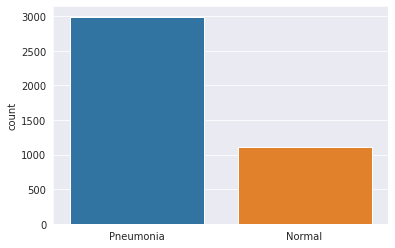

In [ ]:
#Data visualization
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)  

# STEP 3: Normalization and data augmentation

In [ ]:
#As shown above the data seems imbalance so I am going to increase number of training examples, by data augmentation

x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [ ]:
# The CNN converges faster on [0..1] so normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255
x_train.shape

(4099, 150, 150)

In [ ]:
# resize data 
X_train = x_train.reshape(-1, img_size, img_size, 1)
Y_train = np.array(y_train)

X_val = x_val.reshape(-1, img_size, img_size, 1)
Y_val = np.array(y_val)

X_test = x_test.reshape(-1, img_size, img_size, 1)
Y_test = np.array(y_test)
Y_train.shape

(4099,)

In [ ]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

# Step 4 :Training the model

In [ ]:

model = Sequential()
#first conv layer
model.add(Conv2D(16, (3, 3), padding="same", input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(2, 2))
#second conv layer
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.1))
#third conv layer
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))
#fourth conv layer
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(2, 2))
#fifth conv layer
model.add(Conv2D(256, (3, 3), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))
#fc layer
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))

#output layer
model.add(Dense(1))
model.add(Activation("sigmoid"))
#optimizer and loss function
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer =opt , loss = 'binary_crossentropy' , metrics = ['accuracy'])
#model's summary
model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_175 (Conv2D)         (None, 150, 150, 16)      160       
                                                                 
 batch_normalization_175 (Ba  (None, 150, 150, 16)     64        
 tchNormalization)                                               
                                                                 
 activation_210 (Activation)  (None, 150, 150, 16)     0         
                                                                 
 max_pooling2d_175 (MaxPooli  (None, 75, 75, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_176 (Conv2D)         (None, 75, 75, 32)        4640      
                                                                 
 batch_normalization_176 (Ba  (None, 75, 75, 32)     

In [ ]:
#Using callback to help building better model and to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           mode='min',
                           min_delta=0.001,
                           restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience = 2,
                                            verbose=1,
                                            factor=0.3,
                                            min_lr=0.000001)

In [ ]:
history = model.fit(datagen.flow(X_train,Y_train, batch_size = 32) ,
                    epochs = 30 ,
                    validation_data = datagen.flow(X_val, Y_val) ,
                    callbacks = [early_stop,learning_rate_reduction])

Epoch 1/30
129/129 [==============================] - 12s 79ms/step - loss: 0.3888 - accuracy: 0.8204 - val_loss: 1.2806 - val_accuracy: 0.7298 - lr: 1.0000e-04
Epoch 2/30
129/129 [==============================] - 11s 85ms/step - loss: 0.3034 - accuracy: 0.8661 - val_loss: 2.2655 - val_accuracy: 0.7298 - lr: 1.0000e-04
Epoch 3/30
129/129 [==============================] - ETA: 0s - loss: 0.2719 - accuracy: 0.8861
Epoch 3: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
129/129 [==============================] - 12s 90ms/step - loss: 0.2719 - accuracy: 0.8861 - val_loss: 2.1556 - val_accuracy: 0.7298 - lr: 1.0000e-04
Epoch 4/30
129/129 [==============================] - 10s 76ms/step - loss: 0.2529 - accuracy: 0.8966 - val_loss: 2.0512 - val_accuracy: 0.7298 - lr: 3.0000e-05
Epoch 5/30
129/129 [==============================] - 10s 81ms/step - loss: 0.2357 - accuracy: 0.9044 - val_loss: 1.0792 - val_accuracy: 0.7389 - lr: 3.0000e-05
Epoch 6/30
129/129 [=============

In [ ]:
print("Loss of the model is - " , model.evaluate(X_test,Y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,Y_test)[1]*100 , "%")

28/28 [==============================] - 0s 10ms/step - loss: 0.1777 - accuracy: 0.9489
Loss of the model is -  0.1777055710554123
28/28 [==============================] - 0s 9ms/step - loss: 0.1777 - accuracy: 0.9489
Accuracy of the model is -  94.88636255264282 %


# Analysis of Model Training

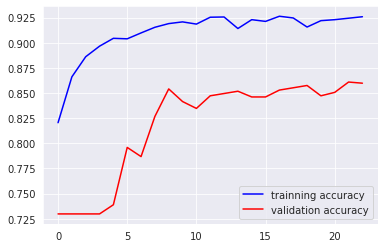

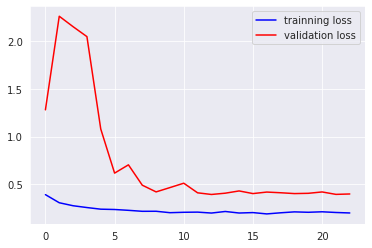

In [ ]:
# visualization
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

# Predictions

In [ ]:
# You could also use "model.predict_classes(x_test)" 
#but it did not work with me bc "predict_classes" removed from my tenseflow version 2.6
predictions = (model.predict(x_test) > 0.5).astype("int32") 
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

28/28 [==============================] - 0s 8ms/step


array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.95      0.98      0.97       642
   Normal (Class 1)       0.94      0.87      0.90       238

           accuracy                           0.95       880
          macro avg       0.95      0.92      0.93       880
       weighted avg       0.95      0.95      0.95       880



In [ ]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

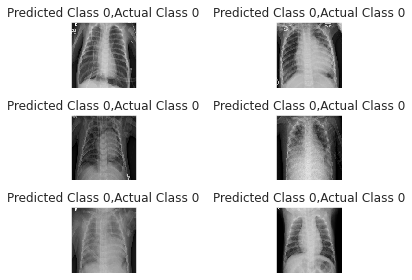

In [ ]:
#Some of the Correctly Predicted Classes
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

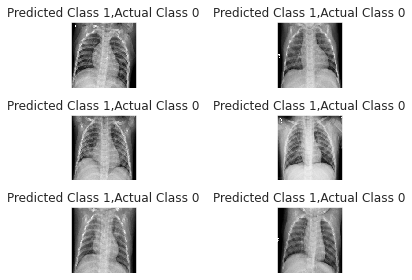

In [ ]:
#Some of the Incorrectly Predicted Classes
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

# Hyper-parameters tuning with k-folds 


**Task 1 - Random search**

In [ ]:
pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.9 MB/s eta 0:00:00


In [ ]:
from kerastuner import HyperModel

NUM_CLASSES=2
INPUT_SHAPE=X_train.shape[1:]

class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = keras.Sequential()
        #First conv layer
        model.add(
            Conv2D(
                filters=16,
                kernel_size=3,
                activation='relu',
                padding='same',
                input_shape=self.input_shape
            )
        )
        model.add(MaxPooling2D(pool_size=2))
        #Second conv layer
        model.add(
            Conv2D(
                filters=hp.Choice(
                    'num_filters_L2',
                    values=[32, 64,128,256],
                    default=32,
                ),
                activation='relu',
                kernel_size=3
            )
        )
        model.add(MaxPooling2D(pool_size=2))
        model.add(
            Dropout(rate=hp.Float(
                'dropout_L2',
                min_value=0.0,
                max_value=0.5,
                default=0.1,
                step=0.05,
            ))
        )
        #Third conv layer
        model.add(
            Conv2D(
                filters=hp.Choice(
                    'num_filters_L3',
                    values=[32, 64,128,256],
                    default=64,
                ),
                activation='relu',
                kernel_size=3
            )
        )
        model.add(MaxPooling2D(pool_size=2))
        model.add(
            Dropout(rate=hp.Float(
                'dropout_L3',
                min_value=0.0,
                max_value=0.5,
                default=0.2,
                step=0.05,
            ))
        )
        #Fourth conv layer
        model.add(
            Conv2D(
                filters=128,
                kernel_size=3,
                activation='relu'
            )
        )
        model.add(MaxPooling2D(pool_size=2))
        #Fifth conv layer
        model.add(
            Conv2D(
                filters=hp.Choice(
                    'num_filters_L3',
                    values=[32, 64,128,256],
                    default=256,
                ),
                activation='relu',
                kernel_size=3
            )
        )
        model.add(MaxPooling2D(pool_size=2))
        model.add(
            Dropout(rate=hp.Float(
                'dropout_L5',
                min_value=0.0,
                max_value=0.5,
                default=0.2,
                step=0.05,
            ))
        )
        model.add(Flatten())
        model.add(
            Dense(
                units=hp.Int(
                    'units_D1',
                    min_value=32,
                    max_value=512,
                    step=32,
                    default=256
                ),
                activation=hp.Choice(
                    'dense1_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'
                )
            )
        )
        model.add(
            Dropout(
                rate=hp.Float(
                    'dropout_D1',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.2,
                    step=0.05
                )
            )
        )
        model.add(
            Dense(
                units=hp.Int(
                    'units_D2',
                    min_value=32,
                    max_value=512,
                    step=32,
                    default=128
                ),
                activation=hp.Choice(
                    'dense2_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'
                )
            )
        )
        model.add(
            Dropout(
                rate=hp.Float(
                    'dropout_D2',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.2,
                    step=0.05
                )
            )
        )
        model.add(Dense(self.num_classes, activation='sigmoid'))

        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-3
                )
            ),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

hypermodel = CNNHyperModel(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)


<ipython-input-102-979dc02a5c42>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


In [ ]:
from kerastuner.tuners import RandomSearch
from kerastuner.tuners import Hyperband

NUM_CLASSES = 2 # chest x ray  number of classes
INPUT_SHAPE = X_train.shape[1:]  # chest x ray images input shape
HYPERBAND_MAX_EPOCHS = 40
MAX_TRIALS = 5
EXECUTION_PER_TRIAL = 2
hypermodel = CNNHyperModel(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    seed=1,
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='random_search',
    project_name='chest_x_ray'
)

tuner = Hyperband(
    hypermodel,
    max_epochs=HYPERBAND_MAX_EPOCHS,
    objective='val_accuracy',
    seed=1,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='hyperband',
    project_name='chest_x_ray'
)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 12
num_filters_L2 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128, 256], 'ordered': True}
dropout_L2 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
num_filters_L3 (Choice)
{'default': 64, 'conditions': [], 'values': [32, 64, 128, 256], 'ordered': True}
dropout_L3 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
dropout_L5 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
units_D1 (Int)
{'default': 256, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dense1_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
dropout_D1 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
units_D2 (Int)

In [ ]:
tuner.search(X_train, Y_train, epochs=15, validation_split=0.1)

Trial 85 Complete [00h 05m 46s]
val_accuracy: 0.9073170721530914

Best val_accuracy So Far: 0.9658536612987518
Total elapsed time: 01h 34m 48s

Search: Running Trial #86

Value             |Best Value So Far |Hyperparameter
128               |256               |num_filters_L2
0.5               |0.45              |dropout_L2
256               |256               |num_filters_L3
0.4               |0.25              |dropout_L3
0.3               |0.2               |dropout_L5
192               |64                |units_D1
sigmoid           |relu              |dense1_activation
0.45              |0.35              |dropout_D1
256               |352               |units_D2
sigmoid           |relu              |dense2_activation
0.15              |0.15              |dropout_D2
0.00021647        |0.00014023        |learning_rate
40                |14                |tuner/epochs
0                 |5                 |tuner/initial_epoch
0                 |3                 |tuner/bracket
0     

116/116 [==============================] - 5s 39ms/step - loss: 0.5043 - accuracy: 0.8062 - val_loss: 1.6545 - val_accuracy: 0.0000e+00
Epoch 2/40
116/116 [==============================] - 4s 37ms/step - loss: 0.4912 - accuracy: 0.8100 - val_loss: 1.0625 - val_accuracy: 0.0000e+00
Epoch 3/40
116/116 [==============================] - 4s 37ms/step - loss: 0.3060 - accuracy: 0.8669 - val_loss: 0.4361 - val_accuracy: 0.8463
Epoch 4/40
116/116 [==============================] - 4s 36ms/step - loss: 0.2477 - accuracy: 0.8929 - val_loss: 0.4016 - val_accuracy: 0.8805
Epoch 5/40
116/116 [==============================] - 4s 36ms/step - loss: 0.2232 - accuracy: 0.9067 - val_loss: 0.4790 - val_accuracy: 0.8390
Epoch 6/40
116/116 [==============================] - 4s 37ms/step - loss: 0.1834 - accuracy: 0.9284 - val_loss: 0.3911 - val_accuracy: 0.8732
Epoch 7/40
116/116 [==============================] - 4s 36ms/step - loss: 0.1610 - accuracy: 0.9368 - val_loss: 0.5690 - val_accuracy: 0.8073
Ep

116/116 [==============================] - 5s 40ms/step - loss: 0.5170 - accuracy: 0.7943 - val_loss: 1.6269 - val_accuracy: 0.0000e+00
Epoch 2/40
116/116 [==============================] - 4s 38ms/step - loss: 0.4787 - accuracy: 0.8100 - val_loss: 1.5804 - val_accuracy: 0.0000e+00
Epoch 3/40
116/116 [==============================] - 4s 37ms/step - loss: 0.3012 - accuracy: 0.8707 - val_loss: 0.4181 - val_accuracy: 0.9049
Epoch 4/40
116/116 [==============================] - 4s 38ms/step - loss: 0.2266 - accuracy: 0.9062 - val_loss: 0.3439 - val_accuracy: 0.9220
Epoch 5/40
116/116 [==============================] - 4s 39ms/step - loss: 0.2269 - accuracy: 0.9067 - val_loss: 0.6969 - val_accuracy: 0.6951
Epoch 6/40
116/116 [==============================] - 4s 39ms/step - loss: 0.1822 - accuracy: 0.9276 - val_loss: 0.7497 - val_accuracy: 0.7293
Epoch 7/40
116/116 [==============================] - 4s 38ms/step - loss: 0.1729 - accuracy: 0.9309 - val_loss: 0.3852 - val_accuracy: 0.8780
Ep

KeyboardInterrupt: ignored

In [ ]:
# Show a summary of the search
tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
loss, accuracy = best_model.evaluate(X_test, Y_test)

Results summary
Results in hyperband/chest_x_ray
Showing 10 best trials
Trial summary
Hyperparameters:
num_filters_L2: 256
dropout_L2: 0.45
num_filters_L3: 256
dropout_L3: 0.25
dropout_L5: 0.2
units_D1: 64
dense1_activation: relu
dropout_D1: 0.35000000000000003
units_D2: 352
dense2_activation: relu
dropout_D2: 0.15000000000000002
learning_rate: 0.00014023399602325874
tuner/epochs: 14
tuner/initial_epoch: 5
tuner/bracket: 3
tuner/round: 2
tuner/trial_id: 0040
Score: 0.9658536612987518
Trial summary
Hyperparameters:
num_filters_L2: 64
dropout_L2: 0.30000000000000004
num_filters_L3: 32
dropout_L3: 0.4
dropout_L5: 0.25
units_D1: 256
dense1_activation: relu
dropout_D1: 0.25
units_D2: 192
dense2_activation: sigmoid
dropout_D2: 0.4
learning_rate: 0.00010854128446585706
tuner/epochs: 14
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.9524390399456024
Trial summary
Hyperparameters:
num_filters_L2: 128
dropout_L2: 0.15000000000000002
num_filters_L3: 32
dropout_L3: 0.05
dropout_L5

**Task 2 - K folds Cross Validation**

In [ ]:
from keras.callbacks import ModelCheckpoint
# Function to create model, required for KerasClassifier
def create_model():

  model = Sequential()
  #first conv layer
  model.add(Conv2D(16, (3, 3), padding="same", input_shape = (150,150,1)))
  model.add(BatchNormalization())
  model.add(Activation("relu"))
  model.add(MaxPooling2D(2, 2))
  #second conv layer
  model.add(Conv2D(32, (3, 3), padding="same"))
  model.add(BatchNormalization())
  model.add(Activation("relu"))
  model.add(MaxPooling2D(2, 2))
  model.add(Dropout(0.2))
  #third conv layer
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(BatchNormalization())
  model.add(Activation("relu"))
  model.add(MaxPooling2D(2, 2))
  model.add(Dropout(0.2))
  #fourth conv layer
  model.add(Conv2D(128, (3, 3), padding="same"))
  model.add(BatchNormalization())
  model.add(Activation("relu"))
  model.add(MaxPooling2D(2, 2))
  #fifth conv layer
  model.add(Conv2D(256, (3, 3), padding="same"))
  model.add(BatchNormalization())
  model.add(Activation("relu"))
  model.add(MaxPooling2D(2, 2))
  model.add(Dropout(0.2))
  #fc layer
  model.add(Flatten())
  model.add(Dense(256, activation="relu"))
  model.add(Dropout(0.2))
  model.add(Dense(128, activation="relu"))
  model.add(Dropout(0.2))

  #output layer
  model.add(Dense(1))
  model.add(Activation("sigmoid"))
  #optimizer and loss function
  opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(optimizer =opt , loss = 'binary_crossentropy' , metrics = ['accuracy'])
  return model
#set early stopping criteria
pat = 5 #this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)

#define the model checkpoint callback -> this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/Project-Deep', verbose=1, save_best_only=True)

#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=20, BATCH_SIZE=128):
    model = None
    model = create_model()
    results = model.fit(t_x, t_y, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping, model_checkpoint], 
              verbose=1, validation_split=0.1)  
    print("Val Score: ", model.evaluate(val_x, val_y))
    return results

In [ ]:
n_folds=5
epochs=20
batch_size=32

#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(x_train, Y_train, test_size=0.1, 
                                               random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/20
104/104 [==============================] - ETA: 0s - loss: 0.3316 - accuracy: 0.8599
Epoch 1: val_loss did not improve from 0.54095
104/104 [==============================] - 4s 31ms/step - loss: 0.3316 - accuracy: 0.8599 - val_loss: 1.0747 - val_accuracy: 0.7317
Epoch 2/20
104/104 [==============================] - ETA: 0s - loss: 0.2121 - accuracy: 0.9148
Epoch 2: val_loss did not improve from 0.54095
104/104 [==============================] - 3s 25ms/step - loss: 0.2121 - accuracy: 0.9148 - val_loss: 2.0109 - val_accuracy: 0.7317
Epoch 3/20
102/104 [============================>.] - ETA: 0s - loss: 0.1907 - accuracy: 0.9246
Epoch 3: val_loss did not improve from 0.54095
104/104 [==============================] - 3s 30ms/step - loss: 0.1900 - accuracy: 0.9253 - val_loss: 2.1890 - val_accuracy: 0.7317
Epoch 4/20
102/104 [============================>.] - ETA: 0s - loss: 0.1678 - accuracy: 0.9384
Epoch 4: val_loss did not improve from 0.54095
104/104 [==

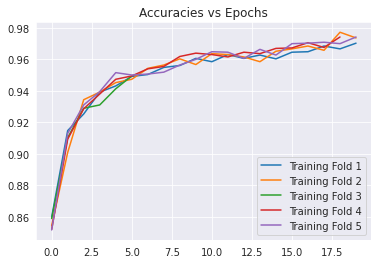

In [ ]:
plt.title('Accuracies vs Epochs')
plt.plot(model_history[0].history['accuracy'], label='Training Fold 1')
plt.plot(model_history[1].history['accuracy'], label='Training Fold 2')
plt.plot(model_history[2].history['accuracy'], label='Training Fold 3')
plt.plot(model_history[3].history['accuracy'], label='Training Fold 4')
plt.plot(model_history[4].history['accuracy'], label='Training Fold 5')
plt.legend()
plt.show()

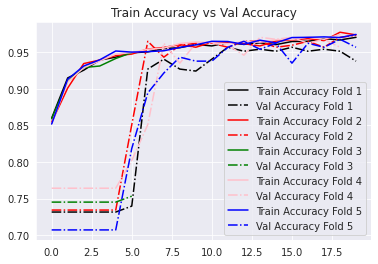

In [ ]:
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.plot(model_history[3].history['accuracy'], label='Train Accuracy Fold 4', color='pink', )
plt.plot(model_history[3].history['val_accuracy'], label='Val Accuracy Fold 4', color='pink', linestyle = "dashdot")
plt.plot(model_history[4].history['accuracy'], label='Train Accuracy Fold 5', color='blue', )
plt.plot(model_history[4].history['val_accuracy'], label='Val Accuracy Fold 5', color='blue', linestyle = "dashdot")
plt.legend()
plt.show()